<a href="https://colab.research.google.com/github/DJCordhose/ml-resources/blob/main/notebooks/jax/intro-jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JAX Intro
## Predict beer consumption as a function of temperature

In [3]:
#@title
import numpy as np
np.random.seed(42)

n = 50
m = 1
b = 2

# noise_level = 1
noise_level = .5
noise = np.random.normal(0, noise_level, n)

title = 'Historic data on beer consumption as a function of temperature'
x_label = 'Temperature * 10'
y_label = 'Halbes per Guest'

# sort is not necessary, but makes x easier to understand
x = np.sort(np.random.uniform(1, 4, n))
# x = np.sort(np.random.uniform(10, 40, n))

y = m*x+b + noise

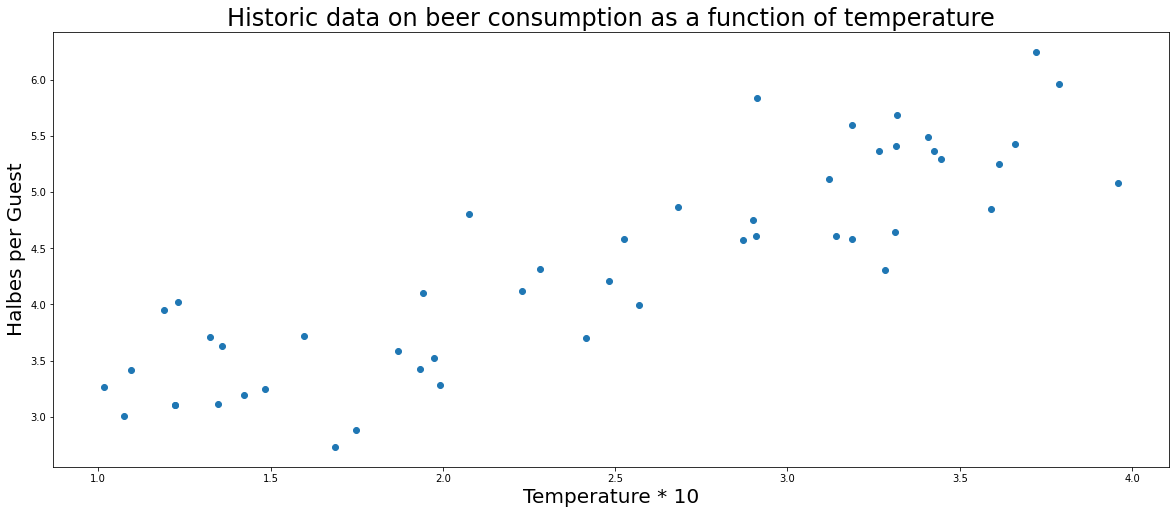

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (20, 10)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.scatter(x, y);

In [7]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

In [6]:
import jax.numpy as jnp

X = jnp.expand_dims(x, axis=1)
Y = y

# model weights
params = {
    'w': jnp.array([0.]),
    'b': 0.
}

def predict(params, X):
    return X@params['w'] + params['b']


In [ ]:
model = LinearModel()
y_pred = model.predict(x)
plt.plot(x, y_pred, color='r');
# plt.scatter(x, y_pred, color='r')
# plt.scatter(x, y);

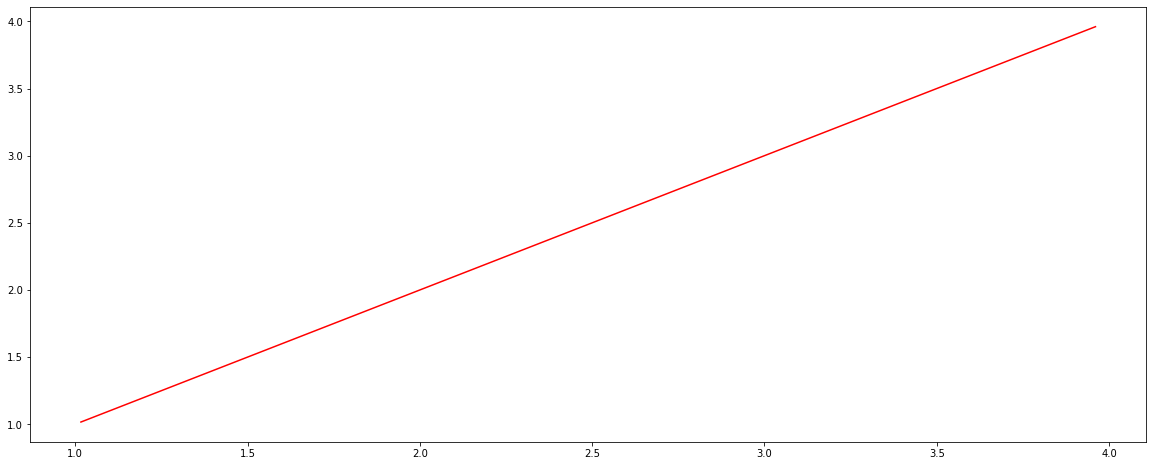

In [103]:
model = LinearModel()
y_pred = model.predict(x)
plt.plot(x, y_pred, color='r');
# plt.scatter(x, y_pred, color='r')
# plt.scatter(x, y);

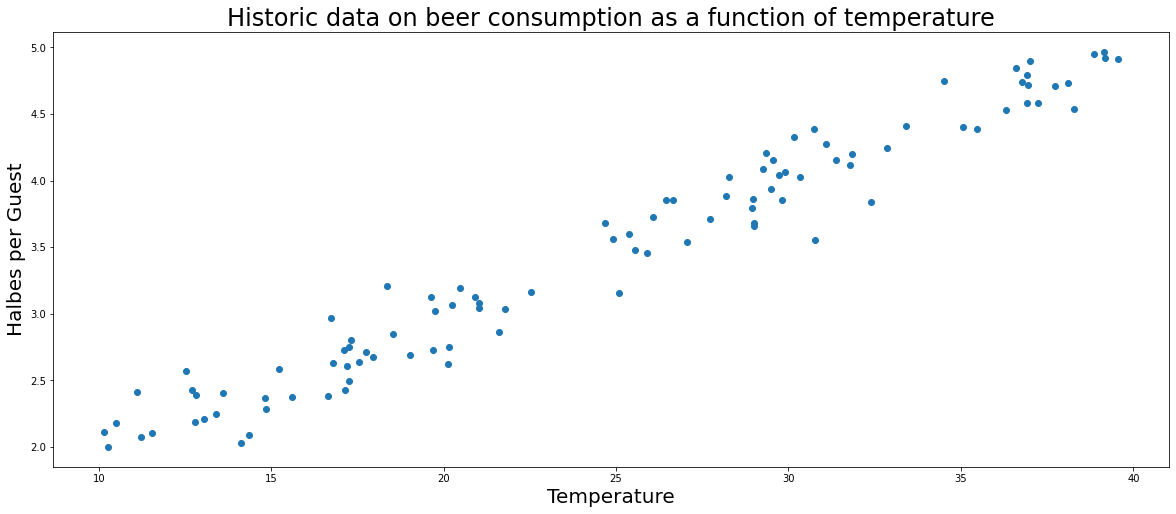

In [82]:
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.scatter(x, y);

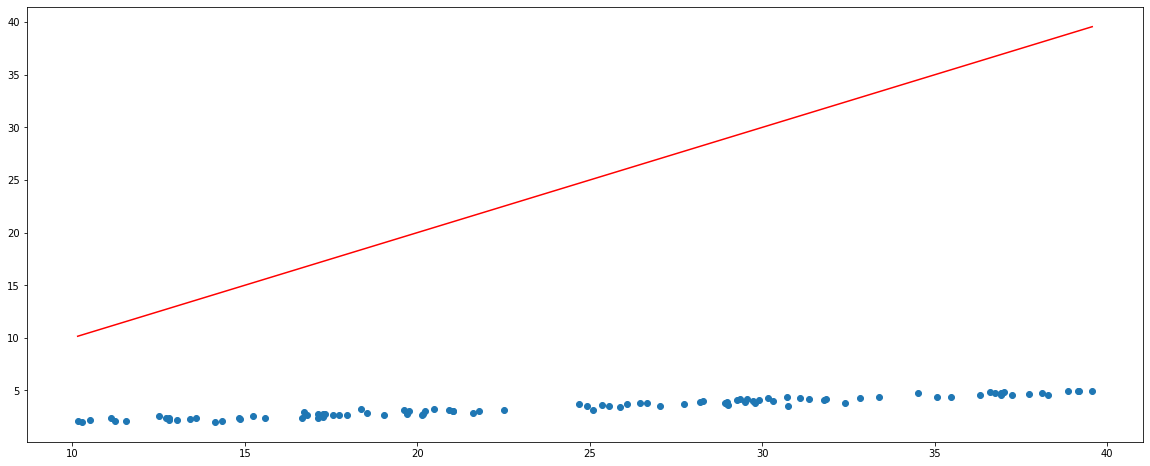

In [83]:
plt.plot(x, y_pred, color='r');
# plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);

### Mean Squared Error

emphasizes larger errors

$MSE = {\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}$


https://en.wikipedia.org/wiki/Mean_squared_error

In [84]:
def mean_squared_error(y_true, y_pred):
  return np.sum(np.square(y_true - y_pred)) / len(y_true)
mean_squared_error(y, y_pred)

507.0576372649827

0.9797154622952093

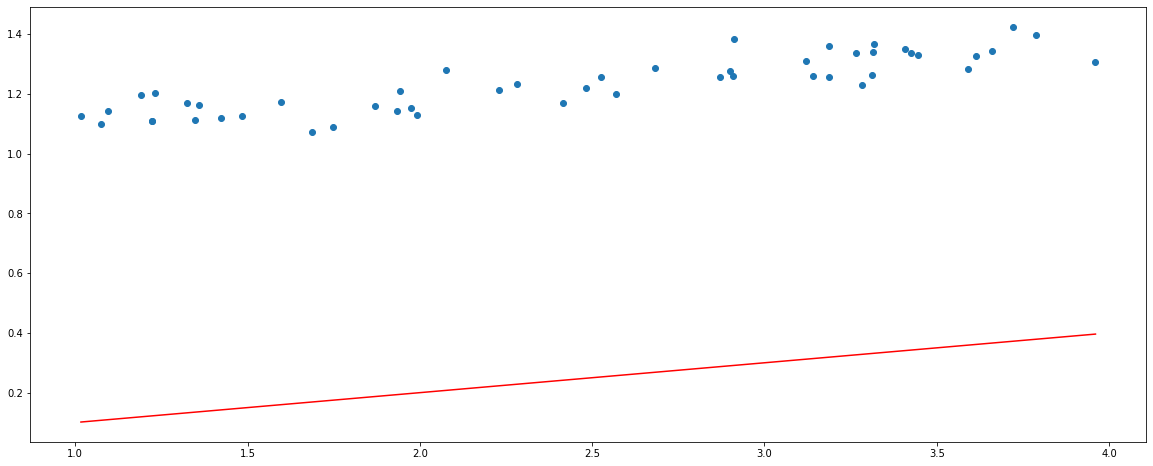

In [118]:
model = LinearModel(m=0.1)
y_pred = model(x)
plt.plot(x, y_pred, color='r');
# plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);
mean_squared_error(y, y_pred)

(0.0330922517547513, (0.10000000000000187, 1.0000000000000027))

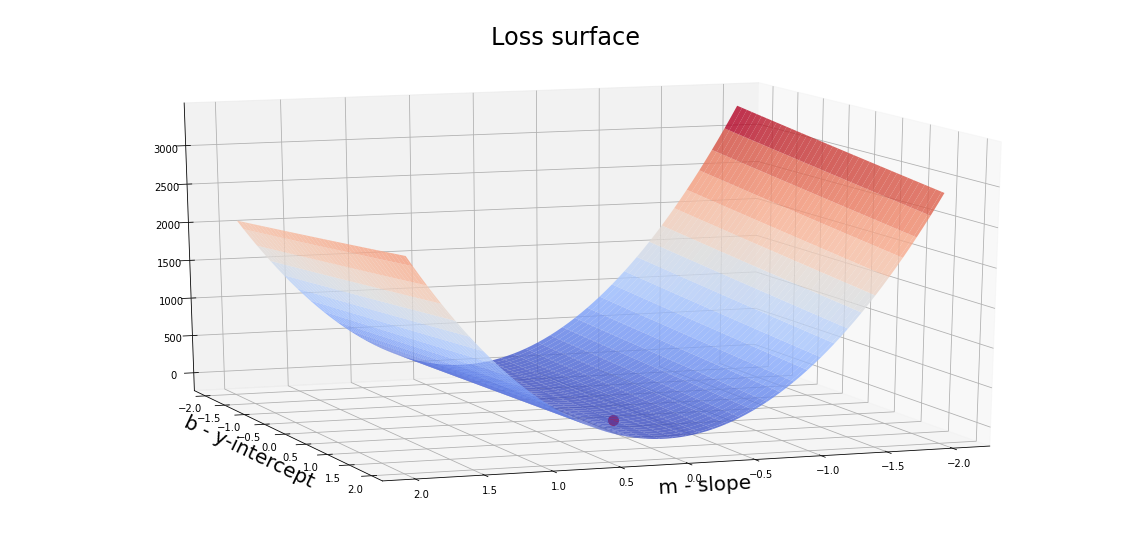

In [86]:
import numpy as np

step = 0.05
m_space = np.arange(-2, 2, step)
b_space = np.arange(-2, 2, step)

sample_size = len(m_space)
losses = np.zeros((sample_size, sample_size))

min_loss = float('inf')
min_params = None

for m_idx in range(sample_size):
  for b_idx in range(sample_size):
    m = m_space[m_idx]
    b = b_space[b_idx]
    model = LinearModel(m=m, b=b)
    y_pred = model.predict(x)
    loss = mean_squared_error(y_true=y, y_pred=y_pred)
    if loss < min_loss:
      min_loss = loss
      min_params = (m, b)
    # the order seems weird, but aparently this is what the 3d plot expects  
    losses[b_idx, m_idx] = loss

# min_loss, min_params

# https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=figsize_3d)
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Loss surface')

M, B = np.meshgrid(m_space, b_space)

# ax.plot_wireframe(W, B, losses)
surf = ax.plot_surface(M, B, losses, cmap=cm.coolwarm, 
                      #  linewidth=0, 
                       alpha=0.8,
                      #  antialiased=False
                       )
# fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('m - slope')
ax.set_ylabel('b - y-intercept')

ax.scatter(min_params[0], min_params[1], min_loss, s=100, color='r')

# https://en.wikipedia.org/wiki/Azimuth
# ax.view_init(elev=30, azim=-60); # default
# ax.view_init(elev=50, azim=60);
ax.view_init(elev=15, azim=70);

min_loss, min_params

0.010549301982142236

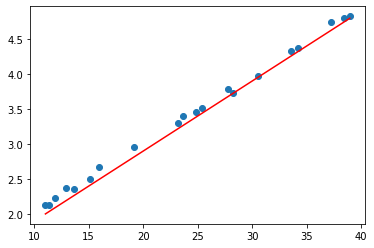

In [124]:
model = LinearModel(m=0.1, b=.9)
y_pred = model(x)
plt.plot(x, y_pred, color='r');
# plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);
mean_squared_error(y, y_pred)

In [88]:
import jax.numpy as np
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

In [89]:
from jax import value_and_grad, grad
import jax.numpy as jnp

def square(x):
  return x ** 2

grad_square = value_and_grad(square)
print(grad_square(3.0))

(DeviceArray(9., dtype=float32, weak_type=True), DeviceArray(6., dtype=float32, weak_type=True))


In [90]:
def loss(m, b):
  return x ** 2


In [91]:
model = LinearModel()

In [92]:
grad_model = grad(model)
# take your guess
# print(grad_model(3.0))

In [93]:
def loss_mse(x, y):
  y_pred = model(x)
  loss = mean_squared_error(y, y_pred)
  return loss

In [94]:
grad_loss = value_and_grad(loss_mse)
grad_loss = value_and_grad(loss_mse)
grad_loss(x, y)

(DeviceArray(507.05765, dtype=float32),
 DeviceArray([0.1607464 , 0.16551946, 0.16636667, 0.17382683, 0.18295519,
              0.18873507, 0.19911872, 0.20568673, 0.21215339, 0.20841411,
              0.21664831, 0.22313862, 0.22375944, 0.24191444, 0.2451429 ,
              0.2490855 , 0.25133082, 0.25290087, 0.26435208, 0.28558743,
              0.2752428 , 0.2832108 , 0.28784436, 0.29402325, 0.29154095,
              0.29015654, 0.2953138 , 0.29025158, 0.29836497, 0.30045524,
              0.3056161 , 0.30305997, 0.31386787, 0.32670513, 0.32993102,
              0.339413  , 0.3348804 , 0.35015082, 0.34838885, 0.3433884 ,
              0.34561932, 0.3556745 , 0.3590291 , 0.35980728, 0.37475115,
              0.37515217, 0.3872445 , 0.42007598, 0.42713973, 0.4384988 ,
              0.43523392, 0.44168726, 0.44871897, 0.4468716 , 0.45219222,
              0.45608333, 0.47024348, 0.48031902, 0.4861466 , 0.48526254,
              0.50273156, 0.5021878 , 0.5063001 , 0.50689083, 0.503447  

In [111]:
make_regression?


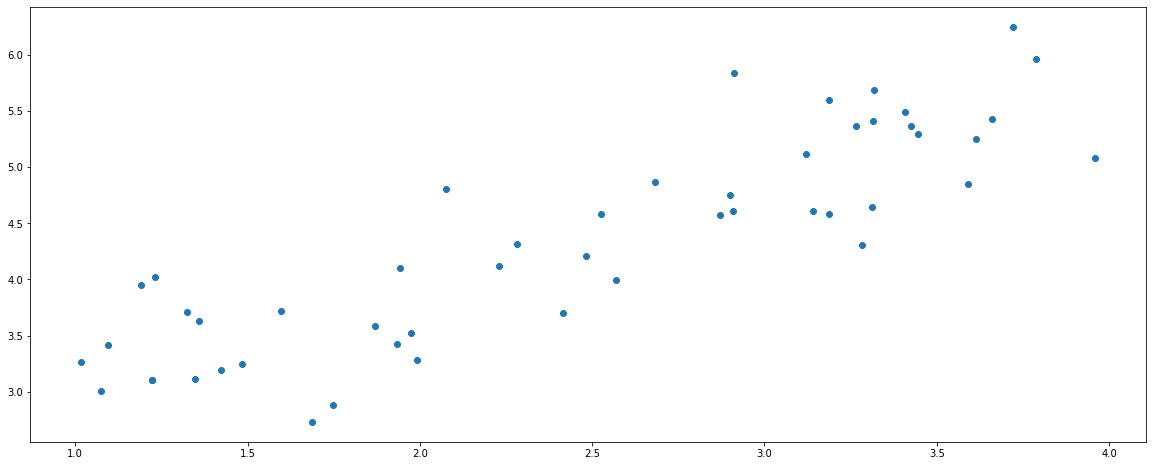

In [148]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

# X, Y = make_regression(n_features=1)
X = np.expand_dims(x, axis=1)
Y = y

plt.scatter(X, Y);

In [158]:
import jax
import jax.numpy as jnp
from sklearn.datasets import make_regression

EPOCHS = 200
# learning_rate = 0.1
learning_rate = 0.1

losses = []

# create our dataset
# X, Y = make_regression(n_features=1)
X = np.expand_dims(x, axis=1)
Y = y

# model weights
params = {
    'w': jnp.array([0.]),
    'b': 0.
}

def predict(params, X):
    return X@params['w'] + params['b']

def loss_fn(params, X, y):
    y_pred = predict(params, X)
    # return mean_squared_error(y, y_pred)
    err = y_pred - y
    return jnp.mean(jnp.square(err))  # mse

def update(params, grads):
    return jax.tree_multimap(lambda p, g: p - learning_rate * g, params, grads)

loss_value_and_grad = jax.value_and_grad(loss_fn)

# the main training loop
for _ in range(EPOCHS):
    loss, grads = loss_value_and_grad(params, X, Y)
    # print(loss)
    # print(grads)
    losses.append(loss)
    # print(params)
    # params['w'] -= learning_rate * grads['w']
    # params['b'] -= learning_rate * grads['b']

    params = update(params, grads)
params    

{'b': DeviceArray(2.1030562, dtype=float32, weak_type=True),
 'w': DeviceArray([0.9108025], dtype=float32)}

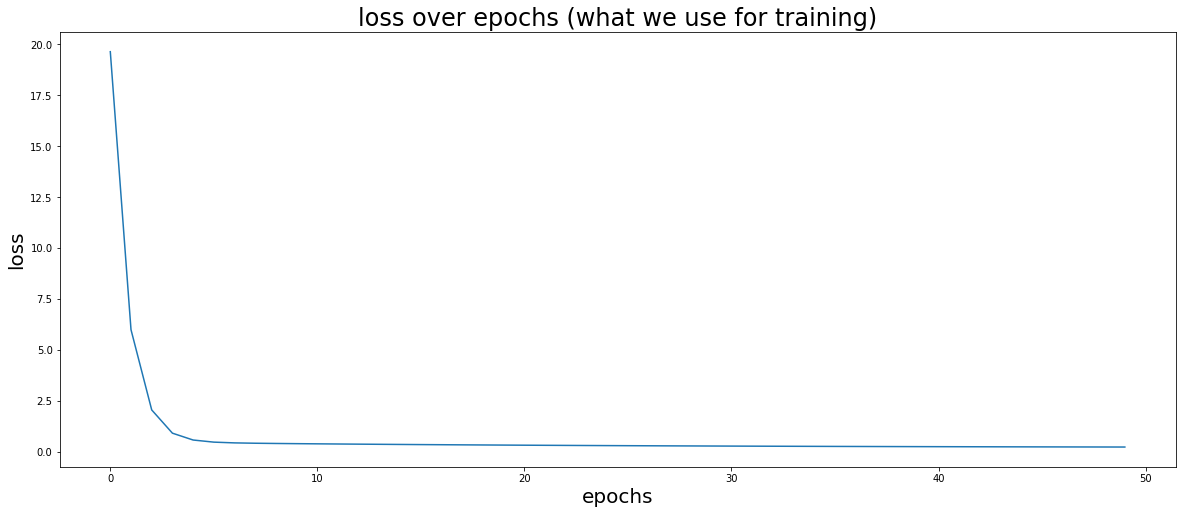

In [155]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss over epochs (what we use for training)')

# plt.yscale('log')

plt.plot(losses);

0.20602544729554478

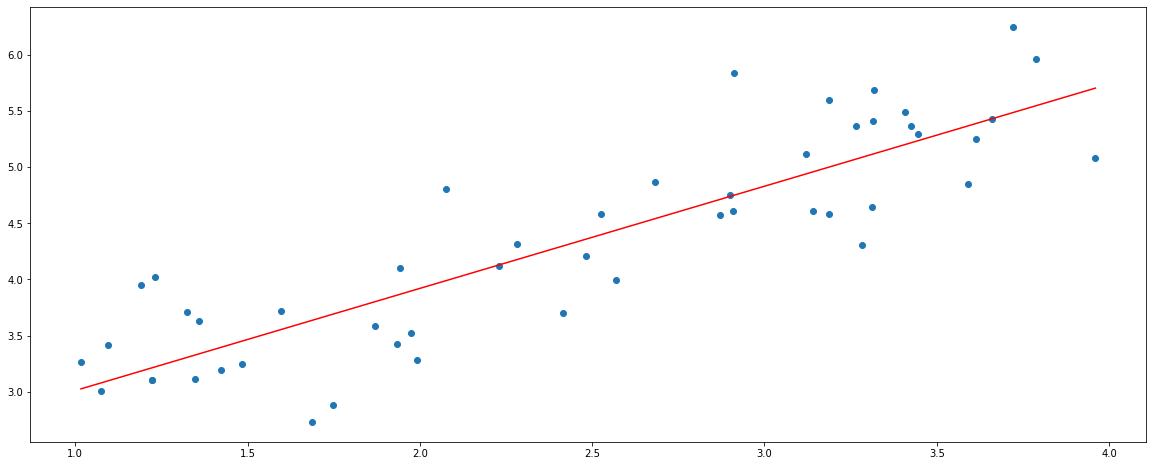

In [159]:
model = LinearModel(m=0.91, b=2.1)
y_pred = model(x)
plt.plot(x, y_pred, color='r');
# plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);
mean_squared_error(y, y_pred)

## Step 3: Finding parameters to tune
 * doing a full grid search is expensive and only works for very few dimensions with a clear domain of values
* why not slide down the slope of the loss function down to the minimum?
* this is what we do in deep learning


### Backpropagation algorithm: The core of how a neural network learns

_In a nutshell:_
1. Predict: Let the network make a prediction 
1. Calculate the loss: how accurate was the predition
1. Record a function of how the trainable parameters affect the loss 
1. partial derivations: find out in which direction to change all parameters to bring down the loss
1. Optimizer: Make changes to parameters based on learning rate and other parameters


### For this we need partial derivations

TensorFlow offers automatic differentiation: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape

* tape will record operations for automatic differentiation
* either by making it record explicily (watch) or 
* by declaring a varible to be trainable (which we did in the layer above) 



In [ ]:
from tensorflow import GradientTape 
# GradientTape?

In [ ]:
def tape_sample():
  x = tf.Variable(3.0)
  with tf.GradientTape() as tape:
    y = x * x
  print("x: {}, y:{}".format(x.numpy(), y.numpy()))
  # how is y dependending on x
  dy_dx = tape.gradient(y, x)
  print("dy/dx: {}".format(dy_dx.numpy()))
  
# just a function in order not to interfere with x on the global scope  
tape_sample()

## Step 4: Intermediate solution: applying all this to our training loop

In [ ]:
%%time

model = tf.keras.Sequential([
  Dense(units=1, input_dim=1)
])

EPOCHS = 1500
learning_rate = 0.01

losses = []
r2s = []

for step in range(EPOCHS):
  with tf.GradientTape() as tape:

    # forward pass, all data
    # often we do not use all data to calculate the loss, but only a certain fraction, called the batch
    # you could also push data through one by one, being an extreme version of a batched approached
    # in our case we use all the data we have and calculate the combined error
    y_pred = model(x_tensor)

    # loss for this batch
    loss = tf.losses.mean_squared_error(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred))
    
  # just for logging
  losses.append(loss)
  
  # metrics
  r2s.append(r2_metric(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred)))

  # get gradients of weights wrt the loss
  # as we have two weights, we get two gradients
  (dw, db) = tape.gradient(loss, model.trainable_weights)
  
  # optimizer: backward pass, changing trainable weights in the direction of the mimimum
  model.trainable_weights[0].assign_sub(learning_rate * dw)
  model.trainable_weights[1].assign_sub(learning_rate * db)

CPU times: user 4.04 s, sys: 51.6 ms, total: 4.09 s
Wall time: 4.03 s


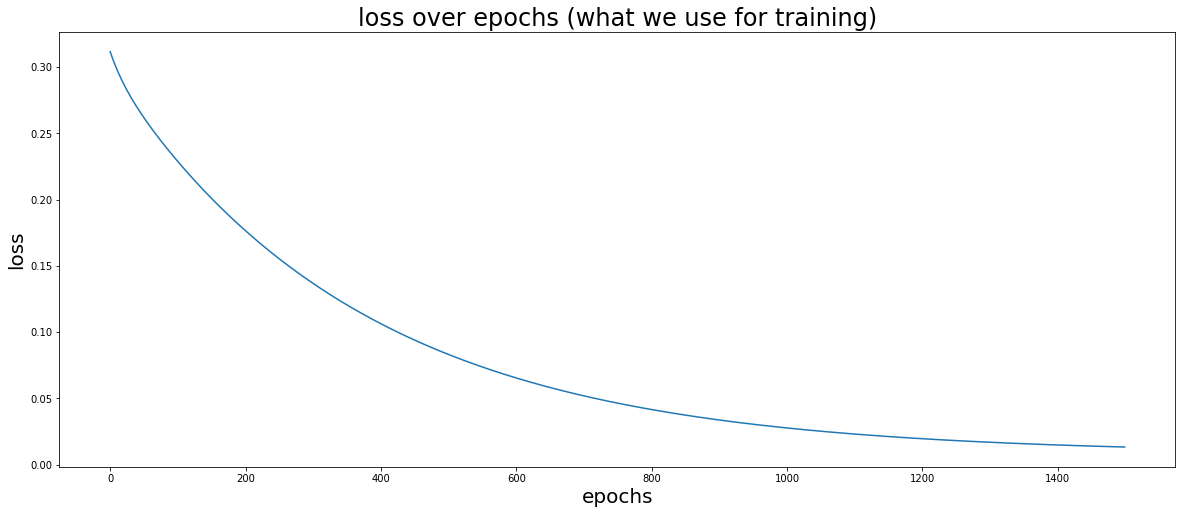

In [ ]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss over epochs (what we use for training)')

# plt.yscale('log')

plt.plot(losses);

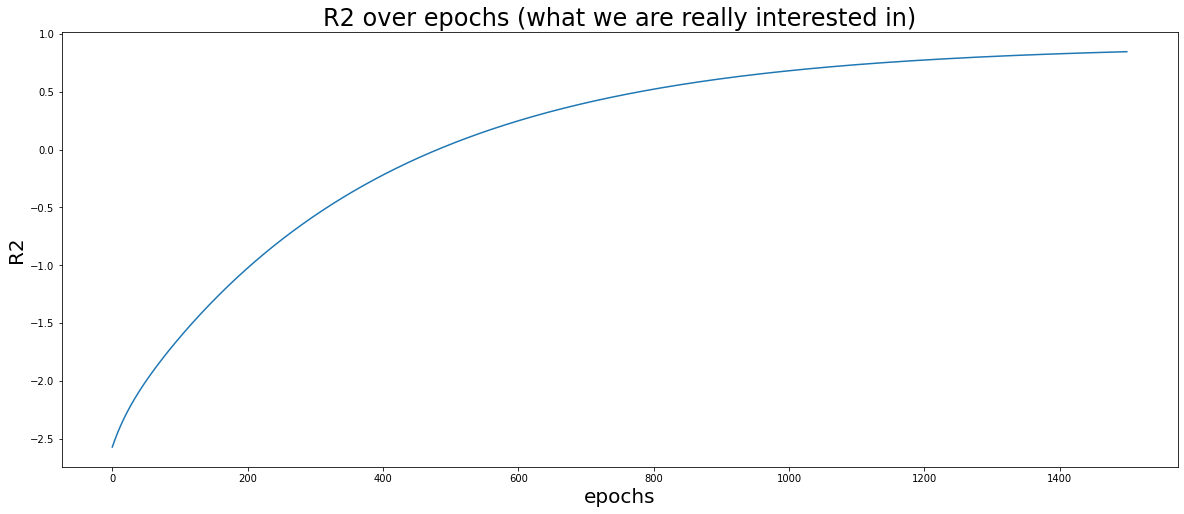

In [ ]:
plt.xlabel('epochs')
plt.ylabel('R2')
plt.title('R2 over epochs (what we are really interested in)')

plt.plot(r2s);

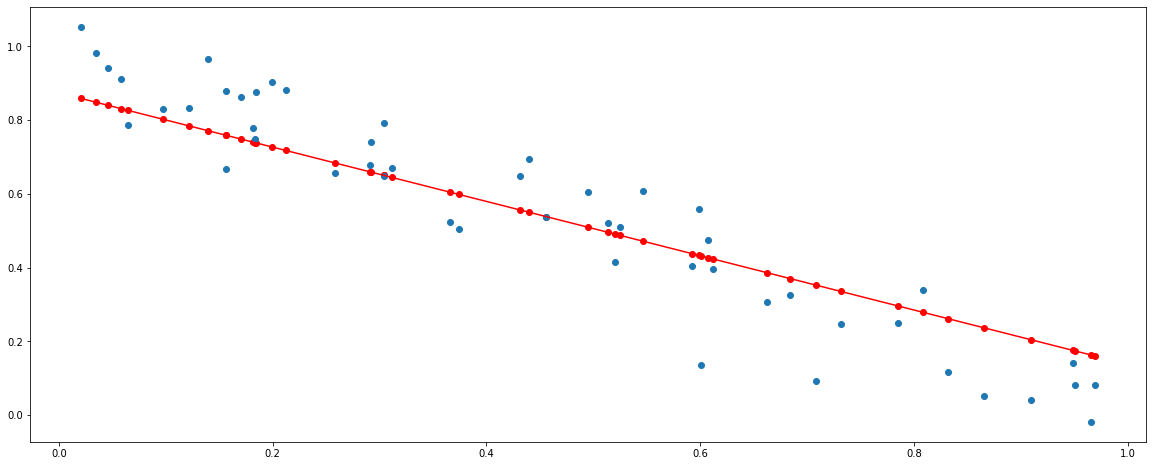

In [ ]:
y_pred = model(x_tensor)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);

## Step 5: Smarter changing of parameters

#### SGD: (Stochastic) Gradient Descent

_w = w - learning_rate * g_

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD

_Note: to make this stochastic it would require us to split our training data into batches and shuffle after each epoch_

### We are already doing this, but prebuilt Optimizers do this job more flexible and with a standard API



In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)

In [ ]:
%%time

model = tf.keras.Sequential([
  Dense(units=1, input_dim=1)
])

EPOCHS = 1500

losses = []
r2s = []

for step in range(EPOCHS):
  with tf.GradientTape() as tape:

    # forward pass, all data
    y_pred = model(x_tensor)

    # loss for this batch
    loss = tf.losses.mean_squared_error(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred))
    
  # just for logging
  losses.append(loss)
  
  # metrics
  r2s.append(r2_metric(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred)))

  # Get gradients of weights wrt the loss.
  gradients = tape.gradient(loss, model.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))

CPU times: user 5.17 s, sys: 57.8 ms, total: 5.22 s
Wall time: 5.14 s


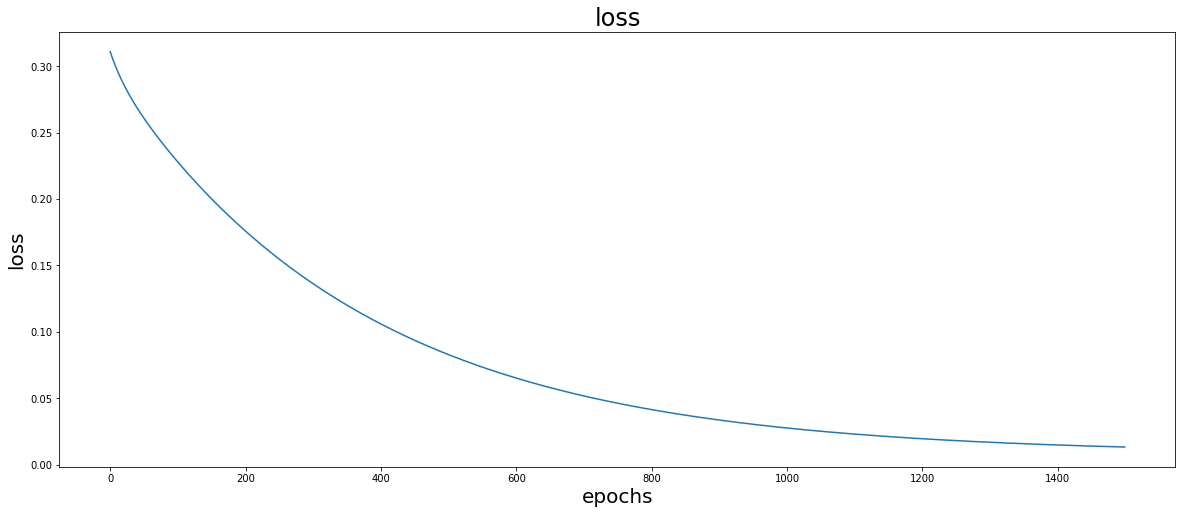

In [ ]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('loss')

plt.plot(losses);

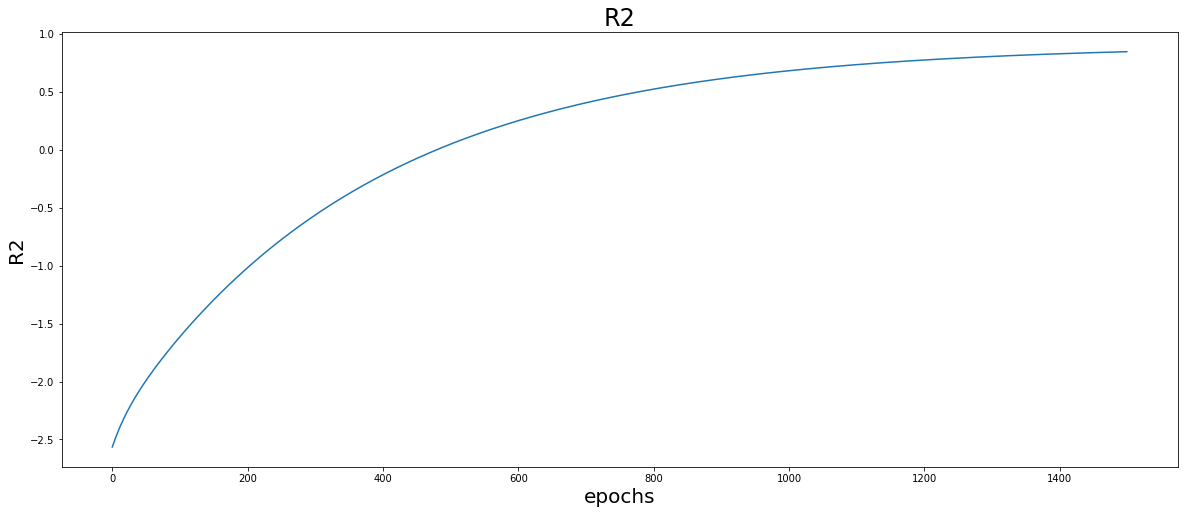

In [ ]:
plt.xlabel('epochs')
plt.ylabel('R2')
plt.title('R2')

plt.plot(r2s);

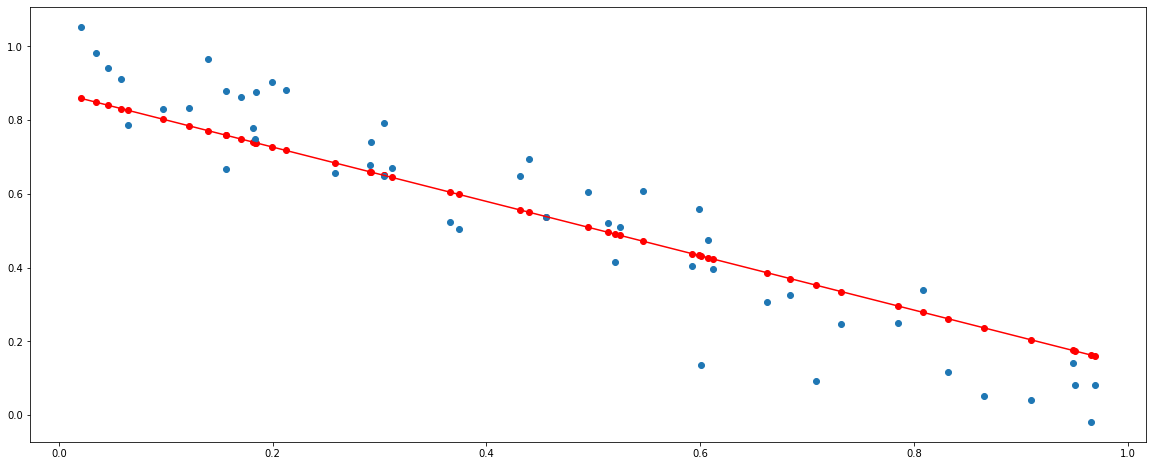

In [ ]:
y_pred = model(x_tensor)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);

# Part III: The same solution using high level Keas API

## Keras vs TensorFlow

<img src='https://djcordhose.github.io/ml-workshop/img/tf-vs-keras.png'>

https://twitter.com/fchollet at http://scaledml.org/2020/

In [ ]:
from tensorflow.keras.layers import Dense
 
model = tf.keras.Sequential([
  Dense(units=1, input_dim=1)                   
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time 

model.compile(loss=tf.losses.mean_squared_error, # mean squared error, unchanged from low level example
             optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2), # SGD, unchanged from low level example
             metrics=[r2_metric]) # we can track the r2 metric over time

# does a similar thing internally as our loop from above
history = model.fit(x, y, epochs=1000, verbose=0)

CPU times: user 3.83 s, sys: 245 ms, total: 4.07 s
Wall time: 3.38 s


In [ ]:
loss, r2 = model.evaluate(x, y, verbose=0)
loss, r2

(0.00981919839978218, 0.594458281993866)

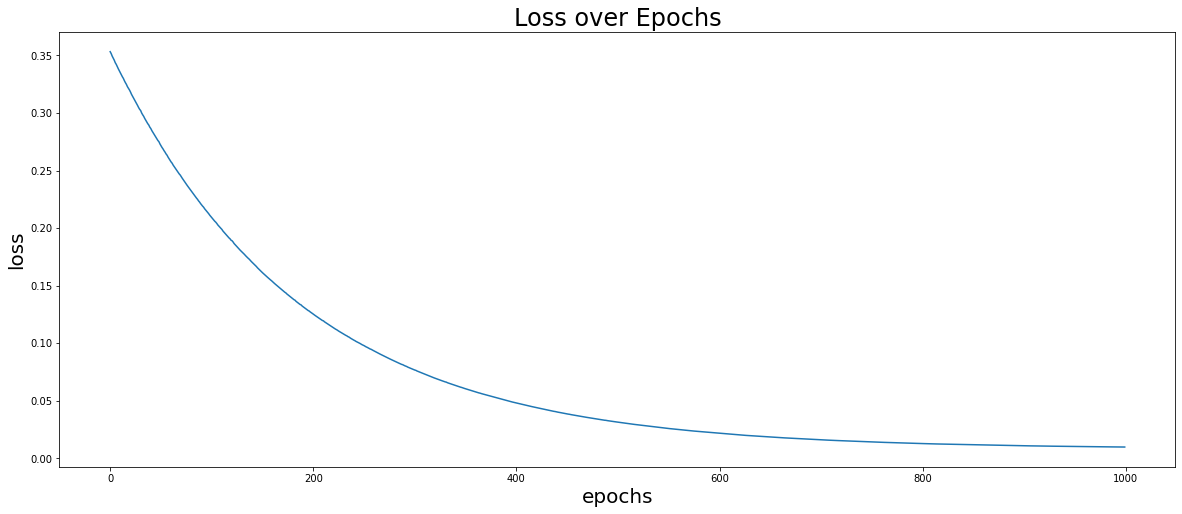

In [ ]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over Epochs')

plt.plot(history.history['loss']);

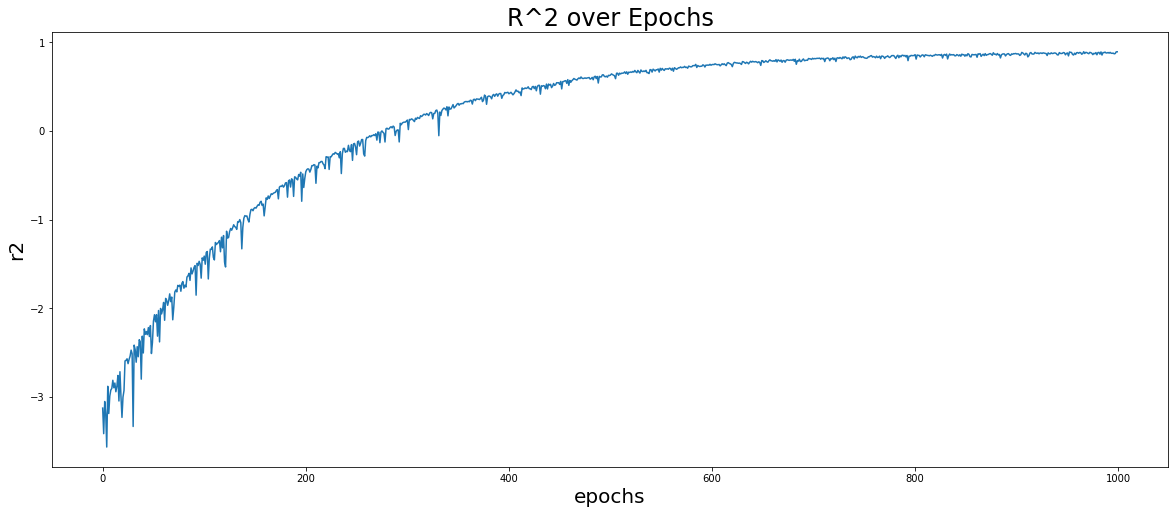

In [ ]:
plt.ylabel("r2")
plt.xlabel("epochs")
plt.title('R^2 over Epochs')
# plt.yscale('log')

plt.plot(history.history['r2_metric']);

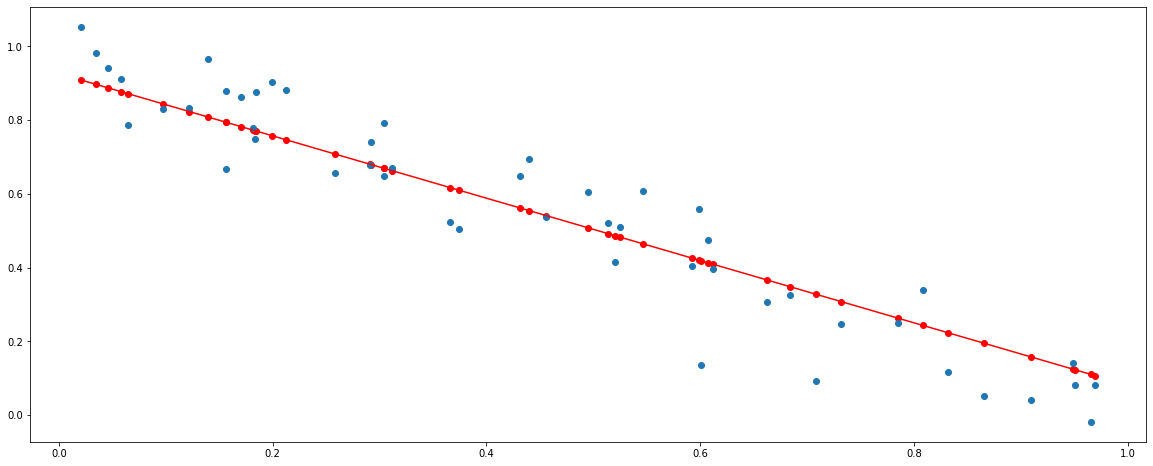

In [ ]:
y_pred = model.predict(x)
plt.plot(x, y_pred, color='red')
plt.scatter(x, y_pred, color='red')
plt.scatter(x, y);

# Hands-On: Fitting arbitrary data

## Choose between three options

1. Adapt the existing example by changing slope, adding noise etc.
1. Use the generator to create a noisy sine wave or any other function
1. Draw something by hand
   * depending on complexity of function might requriw a lot tweaking
   * so might be tricky, as hard as it gets
   * it is likely you will fail, but you will see more powerful approaches later

## Challenges
* do you get good results, if not, why not? what would you need to get better results?
* extend the area of prediction to something off the bounds of the training data
* have a look at this Twitter thread on when and why results might be questionable: https://twitter.com/fchollet/status/1450871559803916290

## Option 1: Adapt original example

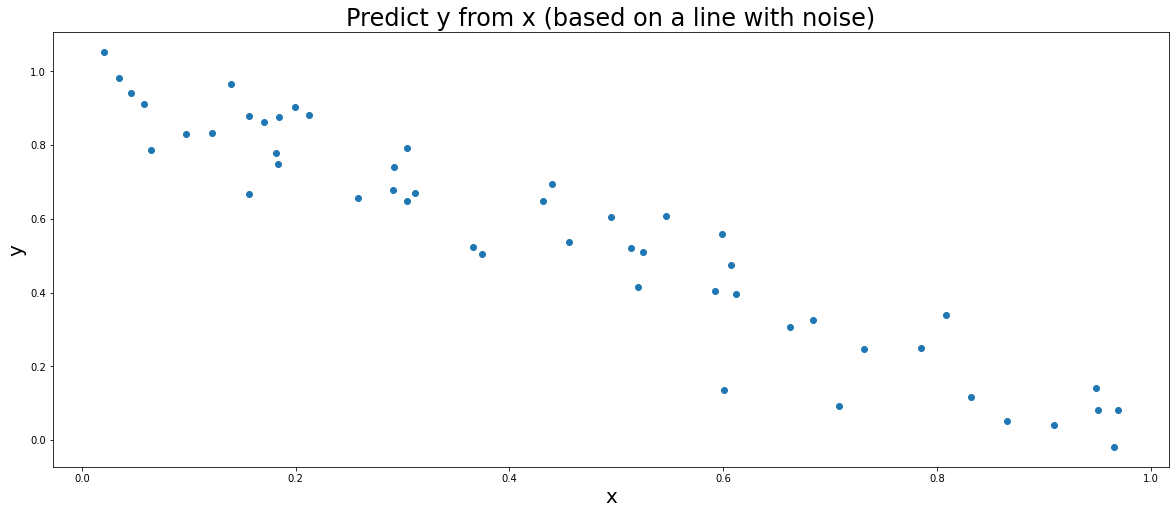

In [ ]:
#@title A noisy line of shape y = m*x + b { run: "auto", display-mode: "form" }

# https://colab.research.google.com/notebooks/forms.ipynb

n = 50 #@param {type:"slider", min:10, max:500, step:1}
m = -1 #@param {type:"slider", min:-10, max:10, step: 0.1}
b = 1 #@param {type:"slider", min:-10, max:10, step: 0.1}

noise_level = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.1}

title = 'Predict y from x (based on a line with noise)' #@param {type:"string"}
x_label = 'x' #@param {type:"string"}
y_label = 'y' #@param {type:"string"}

import numpy as np
np.random.seed(42)

# sort is not necessary, but makes x easier to understand
x = np.sort(np.random.uniform(0, 1, n))
y = m*x+b + np.random.normal(0, noise_level, n)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.scatter(x, y);

In [ ]:
x_tensor = tf.expand_dims(tf.constant(x, dtype=tf.float32), axis=1)
y_tensor = tf.expand_dims(tf.constant(y, dtype=tf.float32), axis=1)

In [ ]:
# your code goes here

## Option 2: Generate data from non linear function

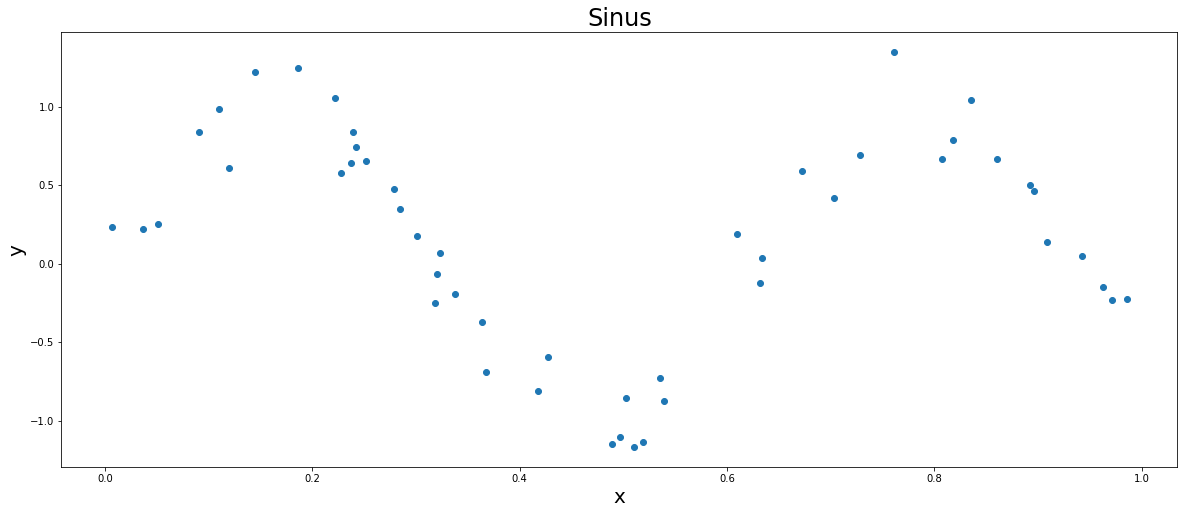

In [ ]:
#@title A noisy sine curve { run: "auto", display-mode: "form" }

n = 50 #@param {type:"slider", min:10, max:500, step:1}
noise_level = 0.2 #@param {type:"slider", min:0.1, max:1.0, step:0.1}
scale = 10 #@param {type:"slider", min:1, max:100, step:1}

import numpy as np

x = np.random.uniform(0, 1, n)
y = np.sin(x*scale) + np.random.normal(0, noise_level, n)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Sinus')

plt.scatter(x, y);

In [ ]:
x_tensor = tf.expand_dims(tf.constant(x, dtype=tf.float32), axis=1)
y_tensor = tf.expand_dims(tf.constant(y, dtype=tf.float32), axis=1)

In [ ]:
# your code goes here

## Option 3: Fitting hand drawn data 

* https://twitter.com/fishnets88/status/1383333912470974470
* https://calmcode.io/labs/drawdata.html
* https://github.com/koaning/drawdata

In [ ]:
 !pip install -q drawdata

     |████████████████████████████████| 792 kB 7.8 MB/s 
     |████████████████████████████████| 374 kB 42.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.31.1 which is incompatible.


In [ ]:
from drawdata import draw_line, draw_scatter, draw_histogram

draw_line()

In [ ]:
# COPY CSV AND MANUALLY PASTE CSV DATA INSIDE QUOTED BLOCK

drawdata_data = """
"""

In [ ]:
from io import StringIO
import pandas as pd

df = pd.read_csv(StringIO(drawdata_data))
df.head()

,x,y,z
0,48,124,a
1,48,125,a
2,49,127,a
3,49,129,a
4,50,131,a


In [ ]:
x = df['x']
y = df['y']

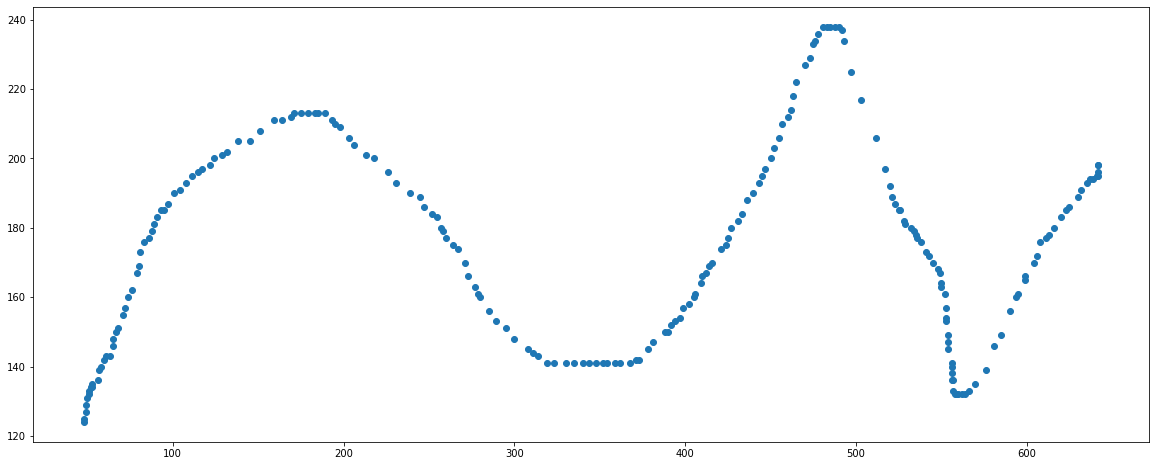

In [ ]:
plt.scatter(x, y);

In [ ]:
x_tensor = tf.expand_dims(tf.constant(x, dtype=tf.float32), axis=1)
y_tensor = tf.expand_dims(tf.constant(y, dtype=tf.float32), axis=1)

In [ ]:
# your code goes here